# Assignment 4 PML

## Question 1:  
Implement Logistic Regression using the Pyro library referring [1] for guidance. Show both the mean prediction as well as standard deviation in the predictions over the 2d grid. Use NUTS MCMC sampling to sample the posterior. Take 1000 samples for posterior distribution and use 500 samples as burn/warm up. Use the below given dataset.
```python
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=100, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)
```

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import seaborn as sns
from jax import random
sns.set_context("notebook")

In [ ]:
try:
    import numpyro
except ImportError:
    %pip install numpyro
    import numpyro

In [ ]:
try:
    import pyro
except ImportError:
    %pip install pyro-ppl
    import pyro

In [ ]:
import pyro.distributions as dist

In [ ]:
from pyro.infer import MCMC, NUTS, Predictive

In [ ]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=100, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)

In [ ]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()
X_train.shape, y_train.shape,X_test.shape, y_test.shape

(torch.Size([80, 2]), torch.Size([80]), torch.Size([20, 2]), torch.Size([20]))

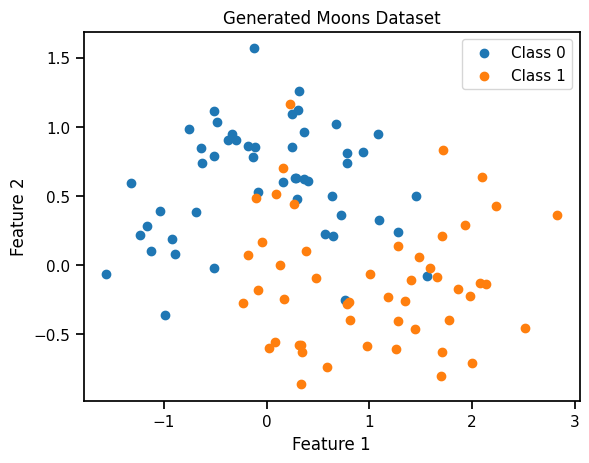

In [ ]:
# Separate data points by class
class_0 = X[y == 0]
class_1 = X[y == 1]

# Create a scatter plot
plt.scatter(class_0[:, 0], class_0[:, 1], label="Class 0", marker='o')
plt.scatter(class_1[:, 0], class_1[:, 1], label="Class 1", marker='o')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Generated Moons Dataset")
plt.legend()
plt.show()

In [ ]:
def logistic_model(X, y):
    # sample from prior
    w = pyro.sample(
      'w', dist.Normal(torch.zeros(X.shape[1]), torch.ones(X.shape[1]))
    )
    b = pyro.sample(
      'b', dist.Normal(torch.zeros(1), torch.ones(1))
    )
    with pyro.iarange('data', X.shape[0]):
        model_logits = torch.matmul(X, w) + b
        pyro.sample('obs', dist.Bernoulli(logits=model_logits), obs=y)

In [ ]:
nuts_kernel = NUTS(logistic_model, adapt_step_size=True)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=500)
mcmc.run(X_train, y_train)

Warmup:   0%|          | 3/1500 [00:00, 25.77it/s, step size=1.20e-01, acc. prob=0.333]

Sample: 100%|██████████| 1500/1500 [00:32, 46.05it/s, step size=6.50e-01, acc. prob=0.929] 


In [ ]:
posterior_samples = mcmc.get_samples()

c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\arviz\data\io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


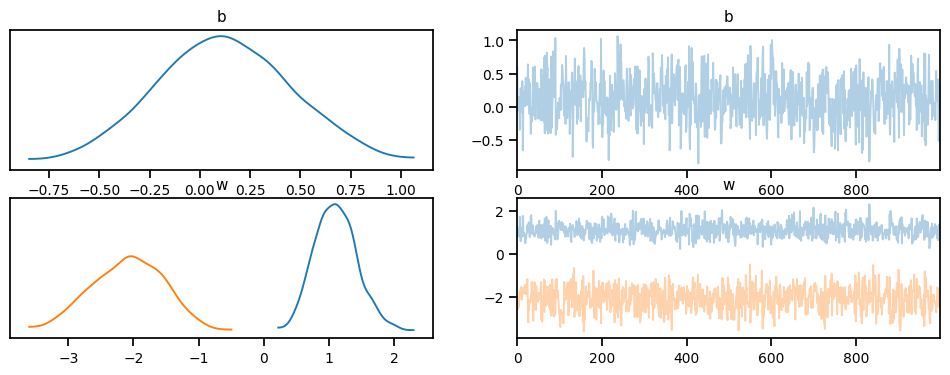

In [ ]:
import arviz as az

idata = az.from_pyro(mcmc)
az.plot_trace(idata, compact=True);

In [ ]:
posterior_samples['w'].mean(0), posterior_samples['b'].mean(0)

(tensor([ 1.1069, -2.0874]), tensor([0.1179]))

In [ ]:
posterior_samples['w'].std(0), posterior_samples['b'].std(0)

(tensor([0.3259, 0.5515]), tensor([0.3369]))

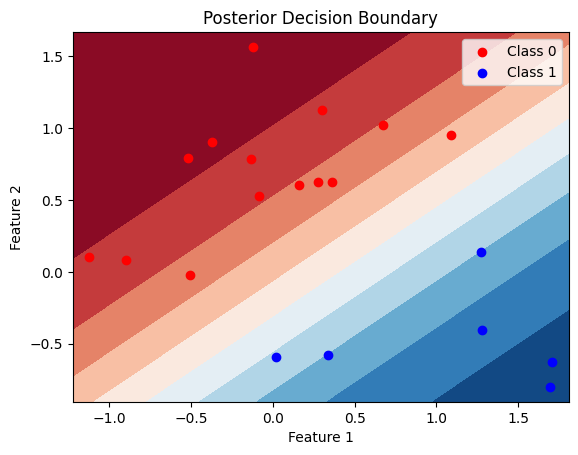

In [ ]:
# Define a function to plot the decision boundary
def plot_decision_boundary(X, y, posterior_samples, title="Posterior Decision Boundary"):
    # Create a meshgrid of points for the entire feature space
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = torch.meshgrid(torch.linspace(x_min, x_max, 100), torch.linspace(y_min, y_max, 100))

    # Flatten the meshgrid for prediction
    grid = torch.cat((xx.reshape(-1, 1), yy.reshape(-1, 1)), dim=1)

    # Get the number of posterior samples
    num_samples = len(posterior_samples['w'])

    # Plot the posterior decision boundary for each sample
    for i in range(num_samples):
        w = posterior_samples['w'][i]
        b = posterior_samples['b'][i]

        # Calculate the logits and probabilities
        logits = torch.matmul(grid, w) + b
        probs = 1 / (1 + torch.exp(-logits))
        probs = probs.detach().numpy().reshape(xx.shape)

        # Plot the decision boundary
        # plt.contourf(xx, yy, probs, levels=[0, 0.5, 1], alpha=0.2, cmap=plt.cm.RdBu)
        plt.contourf(xx, yy, probs, 10, cmap=plt.cm.RdBu)
    # Plot the data points
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], label="Class 0", marker='o', color = 'r')
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], label="Class 1", marker='o', color = 'b')

    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title(title)
    plt.legend()
    plt.show()

# Plot the decision boundary on the test data
plot_decision_boundary(X_test, y_test, posterior_samples)

## Question 2:
Consider the FVC dataset example discussed in the class. Find the notebook link at [2]. We had only used the train dataset. Now, we want to find out the performance of various models on the test dataset. Use the given dataset and deduce which model works best in terms of error (MAE) and coverage? The base model is Linear Regression by Sklearn (from sklearn.linear_model import LinearRegression). Plot the trace diagrams and posterior distribution. Also plot the predictive posterior distribution with 90% confidence interval.


In [ ]:
URL = "https://gist.githubusercontent.com/ucals/" + "2cf9d101992cb1b78c2cdd6e3bac6a4b/raw/"+ "43034c39052dcf97d4b894d2ec1bc3f90f3623d9/"+ "osic_pulmonary_fibrosis.csv"

In [ ]:
df = pd.read_csv(URL)
df.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df["Weeks"], df['FVC'], train_size = 0.8, random_state = 0)

print(f"Training set shape: {x_train.shape}")
print(f"Testing set shape: {x_test.shape}")


Training set shape: (1239,)
Testing set shape: (310,)


In [ ]:
### Linear regression from scikit-learn
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(x_train.values.reshape(-1,1), y_train)

LinearRegression()

In [ ]:
all_weeks = np.arange(-12, 134, 1)

Text(0.5, 1.0, 'Linear Regression predictions on test data')

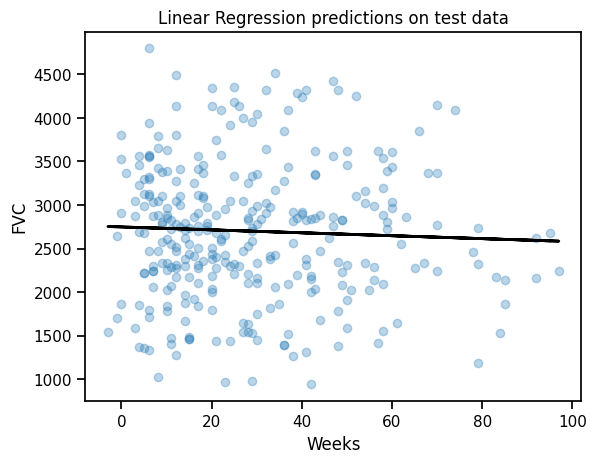

In [ ]:
# Plot the data and the regression line
plt.scatter(x_test.values.reshape(-1,1), y_test, alpha=0.3)
plt.plot(x_test, lr.predict(x_test.values.reshape(-1,1)), color="black", lw=2)
plt.xlabel("Weeks")
plt.ylabel("FVC")
plt.title("Linear Regression predictions on test data")

Prediction: Vanilla LR

In [ ]:
predictions = lr.predict(x_test.values.reshape(-1, 1))

from sklearn.metrics import mean_absolute_error

maes = {}
maes["LinearRegression"] = mean_absolute_error(y_test.values, predictions)
maes

{'LinearRegression': 626.3184730275215}

### Pooled model

$\alpha \sim \text{Normal}(0, 500)$

$\beta \sim \text{Normal}(0, 500)$

$\sigma \sim \text{HalfNormal}(100)$

`for i in range(N_Weeks):`

$FVC_i \sim \text{Normal}(\alpha + \beta \cdot Week_i, \sigma)$



In [ ]:
def pooled_model(X, y=None):
    α = numpyro.sample("α", dist.Normal(0., 500.))
    β = numpyro.sample("β", dist.Normal(0., 500.))
    σ = numpyro.sample("σ", dist.HalfNormal(50.))
    with numpyro.plate("samples", len(X)):
        fvc = numpyro.sample("fvc", dist.Normal(α + β * X, σ), obs=y)
    return fvc

In [ ]:
import numpyro.distributions as dist

In [ ]:
from sklearn.preprocessing import LabelEncoder

patient_encoder = LabelEncoder()
df["patient_code"] = patient_encoder.fit_transform(df["Patient"].values)

In [ ]:
sample_patient_code_train = df["patient_code"].values[x_train.index]
sample_patient_code_test = df["patient_code"].values[x_test.index]

In [ ]:
from numpyro.infer import MCMC, NUTS, Predictive

In [ ]:

nuts_kernel = NUTS(pooled_model)

mcmc = MCMC(nuts_kernel, num_samples=4000, num_warmup=2000)
rng_key = random.PRNGKey(0)


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [ ]:
x_train.values.reshape(-1,1).shape, y_train.values.shape

((1239, 1), (1239,))

In [ ]:
mcmc.run(rng_key, X=x_train.values, y=y_train.values)
posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 6000/6000 [00:07<00:00, 780.32it/s, 15 steps of size 4.41e-01. acc. prob=0.93] 


array([[<Axes: title={'center': 'α'}>, <Axes: title={'center': 'α'}>],
       [<Axes: title={'center': 'β'}>, <Axes: title={'center': 'β'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>]],
      dtype=object)

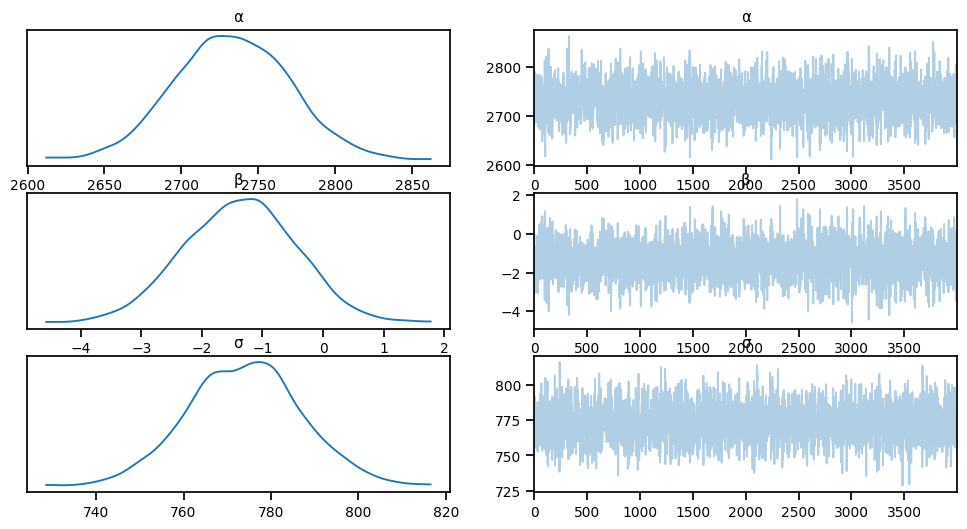

In [ ]:
import arviz as az

idata = az.from_numpyro(mcmc)
az.plot_trace(idata, compact=True)

In [ ]:
# Summary statistics
az.summary(idata, round_to=2)

arviz - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,2732.55,36.72,2666.72,2804.27,0.86,0.61,1831.78,2063.36,NaN
β,-1.37,0.92,-3.15,0.25,0.02,0.02,1918.32,2020.37,NaN
σ,773.88,12.85,749.97,798.30,0.25,0.18,2569.03,1991.23,NaN


In [ ]:
# Predictive distribution
predictive = Predictive(pooled_model, mcmc.get_samples())

In [ ]:
predictions = predictive(rng_key, x_test.values, None)

<Axes: >

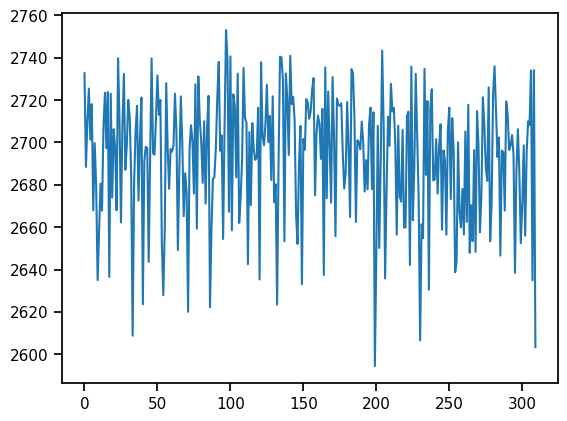

In [ ]:
pd.DataFrame(predictions["fvc"]).mean().plot()

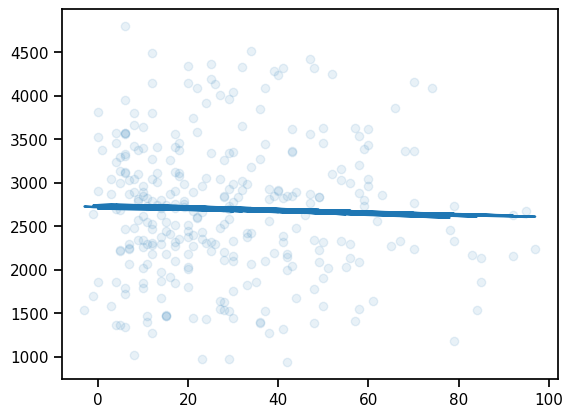

In [ ]:
plt.plot(x_test, predictions["fvc"].mean(axis=0))
plt.scatter(x_test, y_test, alpha=0.1)

Text(0, 0.5, 'FVC')

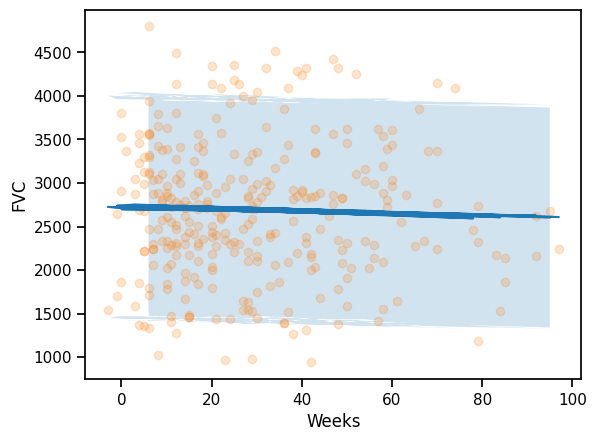

In [ ]:
# Get the mean and standard deviation of the predictions
mu = predictions["fvc"].mean(axis=0)
sigma = predictions["fvc"].std(axis=0)

# Plot the predictions
plt.plot(x_test, mu)
plt.fill_between(x_test, mu - 1.64*sigma, mu + 1.64*sigma, alpha=0.2)
plt.scatter(x_test, y_test, alpha=0.2)
plt.xlabel("Weeks")
plt.ylabel("FVC")

In [ ]:
preds_pooled  = predictive(rng_key, x_test.values, None)['fvc']
predictions_train_pooled = preds_pooled.mean(axis=0)
std_train_pooled = preds_pooled.std(axis=0)

In [ ]:
### Computing Mean Absolute Error and Coverage at 95% confidence interval

maes["PooledModel"] = mean_absolute_error(y_test, predictions_train_pooled)
maes

{'LinearRegression': 626.3184730275215, 'PooledModel': 626.4611966040827}

In [ ]:
### Computing the coverage at 95% confidence interval

def coverage(y_true, y_pred, sigma):
    lower = y_pred - 1.96 * sigma
    upper = y_pred + 1.96 * sigma
    return np.mean((y_true >= lower) & (y_true <= upper))
coverages = {}
coverages["pooled"] = coverage(y_test, predictions_train_pooled, std_train_pooled).item()
coverages

{'pooled': 0.9483870967741935}

### Hierarchical model

$\sigma \sim \text{HalfNormal}(100)$

---

$\mu_{\alpha} \sim \text{Normal}(0, 500)$

$\sigma_{\alpha} \sim \text{HalfNormal}(100)$

$\mu_{\beta} \sim \text{Normal}(0, 500)$

$\sigma_{\beta} \sim \text{HalfNormal}(100)$

---

`for p in range(N_patients):`

$\alpha_p \sim \text{Normal}(\mu_{\alpha}, \sigma_{\alpha})$

$\beta_p \sim \text{Normal}(\mu_{\beta}, \sigma_{\beta})$

---

`for i in range(N_Weeks):`

$FVC_i \sim \text{Normal}(\alpha_{p[i]} + \beta_{p[i]} \cdot Week_i, \sigma)$


In [ ]:
### Hierarchical model

def partial_pool_same_sigma(sample_weeks, sample_patient_code, sample_fvc=None):
    μ_α = numpyro.sample("μ_α", dist.Normal(0.0, 500.0))
    σ_α = numpyro.sample("σ_α", dist.HalfNormal(100.0))
    μ_β = numpyro.sample("μ_β", dist.Normal(0.0, 3.0))
    σ_β = numpyro.sample("σ_β", dist.HalfNormal(3.0))

    n_patients = len(np.unique(sample_patient_code))

    with numpyro.plate("Participants", n_patients):
        α = numpyro.sample("α", dist.Normal(μ_α, σ_α))
        β = numpyro.sample("β", dist.Normal(μ_β, σ_β))

    σ = numpyro.sample("σ", dist.HalfNormal(100.0))
    FVC_est = α[sample_patient_code] + β[sample_patient_code] * sample_weeks

    with numpyro.plate("data", len(sample_patient_code)):
        numpyro.sample("fvc", dist.Normal(FVC_est, σ), obs=sample_fvc)

In [ ]:
nuts_ppss = NUTS(partial_pool_same_sigma)

mcmc_ppss = MCMC(nuts_ppss, num_samples=4000, num_warmup=2000)
rng_key = random.PRNGKey(0)

In [ ]:
model_kwargs = {"sample_weeks": x_train.values,
                "sample_patient_code": sample_patient_code_train,
                "sample_fvc":y_train.values}

In [ ]:
mcmc_ppss.run(rng_key, **model_kwargs)

sample: 100%|██████████| 6000/6000 [01:28<00:00, 67.52it/s, 63 steps of size 1.26e-02. acc. prob=0.85]  


In [ ]:
predictive_ppss = Predictive(partial_pool_same_sigma, mcmc_ppss.get_samples())

array([[<Axes: title={'center': 'α'}>, <Axes: title={'center': 'α'}>],
       [<Axes: title={'center': 'β'}>, <Axes: title={'center': 'β'}>],
       [<Axes: title={'center': 'μ_α'}>, <Axes: title={'center': 'μ_α'}>],
       [<Axes: title={'center': 'μ_β'}>, <Axes: title={'center': 'μ_β'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>],
       [<Axes: title={'center': 'σ_α'}>, <Axes: title={'center': 'σ_α'}>],
       [<Axes: title={'center': 'σ_β'}>, <Axes: title={'center': 'σ_β'}>]],
      dtype=object)

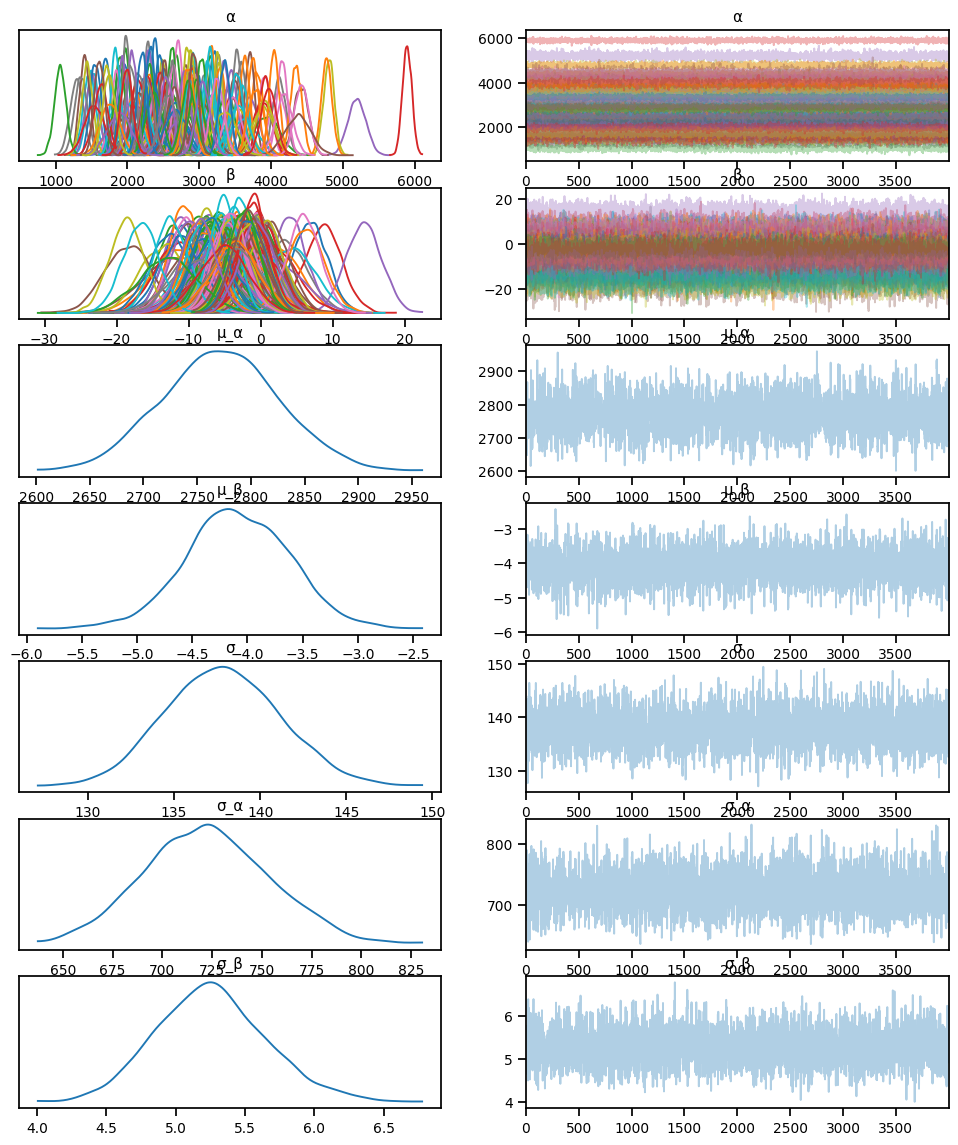

In [ ]:
az.plot_trace(az.from_numpyro(mcmc_ppss), compact=True)

In [ ]:
predictive_ppss = Predictive(partial_pool_same_sigma, mcmc_ppss.get_samples())


In [ ]:
predictions_test_ppss = predictive_ppss(rng_key,
                                                         sample_weeks = x_test.values,
                                                         sample_patient_code = sample_patient_code_test)['fvc']

mu_predictions_test_h = predictions_test_ppss.mean(axis=0)
std_predictions_test_h = predictions_test_ppss.std(axis=0)

maes["PatrialPooled_samesigma"] = mean_absolute_error(y_test, mu_predictions_test_h)

coverages["PatrialPooled_samesigma"] = coverage(y_test, mu_predictions_test_h, std_predictions_test_h).item()

print(maes)
print(coverages)

{'LinearRegression': 626.3184730275215, 'PooledModel': 626.4611966040827, 'PatrialPooled_samesigma': 110.46457322643649}
{'pooled': 0.9483870967741935, 'PatrialPooled_samesigma': 0.9419354838709677}


In [ ]:
# Predict for a given patient


def predict_ppss(patient_code):
    predictions = predictive_ppss(rng_key, all_weeks, patient_code)
    mu = predictions["fvc"].mean(axis=0)
    sigma = predictions["fvc"].std(axis=0)
    return mu, sigma

# Plot the predictions for a given patient
def plot_patient_ppss(patient_code):
    mu, sigma = predict_ppss(patient_code)
    plt.scatter(all_weeks, mu)
    plt.fill_between(all_weeks, mu - 1.64*sigma, mu + 1.64*sigma, alpha=0.1)
    id_to_patient = patient_encoder.inverse_transform([patient_code])[0]

    patient_weeks = x_test.values[sample_patient_code_test == patient_code]
    patient_fvc = y_test.values[sample_patient_code_test == patient_code]

    plt.scatter(patient_weeks, patient_fvc, alpha=0.8, label="Test Set", color="black")
    plt.xlabel("Weeks")
    plt.ylabel("FVC")
    plt.legend()
    plt.title(patient_encoder.inverse_transform([patient_code])[0])

def plot_total_ppss(patient_id = 0, plot_pooled = False):
    print(all_weeks.shape)
    print(mu.shape)
    plot_patient_ppss(np.array([patient_id]))
    print(all_weeks.shape)
    print(mu.shape)
    if plot_pooled:
        plt.plot(all_weeks, mu, color='g')
        plt.fill_between(all_weeks, mu - 1.64*sigma, mu + 1.64*sigma, alpha=0.05, color='g')


c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


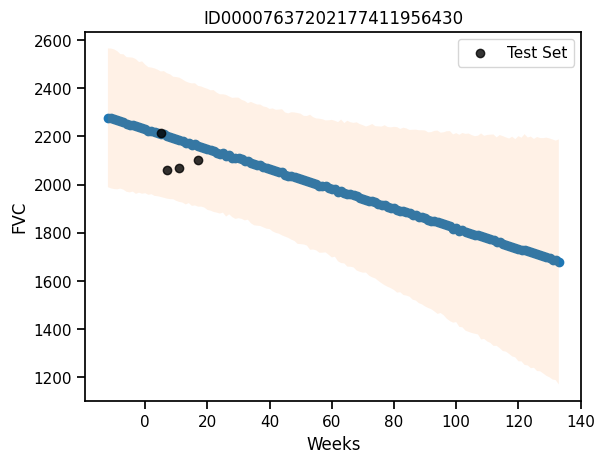

In [ ]:
# plot for a given patient
plot_patient_ppss(np.array([0]))

In [ ]:
predictions_test_ppss = predictive_ppss(rng_key,
                                                 x_test.values,
                                                 sample_patient_code_test)['fvc']
predictions_test_ppss.shape

(4000, 310)

In [ ]:
mu_predictions_test_ppss = predictions_test_ppss.mean(axis=0)
std_predictions_test_ppss = predictions_test_ppss.std(axis=0)

maes["PartialPooled_samesigma"] = mean_absolute_error(y_test, mu_predictions_test_ppss)
maes

{'LinearRegression': 626.3184730275215,
 'PooledModel': 626.4611966040827,
 'PatrialPooled_samesigma': 110.46457322643649,
 'PartiallyPooled_samesigma': 110.46457322643649,
 'PatrialPooled_hypersigma': 111.37391593686996,
 'PartialPooled_samesigma': 110.46457322643649}

### Hierarchical model

$\gamma_{\sigma} \sim \text{HalfNormal}(30)$

$\mu_{\alpha} \sim \text{Normal}(0, 500)$

$\sigma_{\alpha} \sim \text{HalfNormal}(100)$

$\mu_{\beta} \sim \text{Normal}(0, 500)$

$\sigma_{\beta} \sim \text{HalfNormal}(100)$

---

`for p in range(N_patients):`

$\alpha_p \sim \text{Normal}(\mu_{\alpha}, \sigma_{\alpha})$

$\beta_p \sim \text{Normal}(\mu_{\beta}, \sigma_{\beta})$

$\sigma_p \sim \text{Exp}(\gamma_{\sigma})$


---

`for i in range(N_Weeks):`

$FVC_i \sim \text{Normal}(\alpha_{p[i]} + \beta_{p[i]} \cdot Week_i, \sigma_{p[i]})$


In [ ]:
### Hierarchical model

def partial_pool_hyper_sigma(sample_weeks, sample_patient_code, sample_fvc=None):
    μ_α = numpyro.sample("μ_α", dist.Normal(0.0, 500.0))
    σ_α = numpyro.sample("σ_α", dist.HalfNormal(100.0))
    μ_β = numpyro.sample("μ_β", dist.Normal(0.0, 3.0))
    σ_β = numpyro.sample("σ_β", dist.HalfNormal(3.0))
    gamma_sigma = numpyro.sample("gamma_sigma", dist.HalfNormal(30))


    n_patients = len(np.unique(sample_patient_code))

    with numpyro.plate("Participants", n_patients):
        α = numpyro.sample("α", dist.Normal(μ_α, σ_α))
        β = numpyro.sample("β", dist.Normal(μ_β, σ_β))
        σ = numpyro.sample("σ", dist.Exponential(gamma_sigma))
    FVC_est = α[sample_patient_code] + β[sample_patient_code] * sample_weeks

    with numpyro.plate("data", len(sample_patient_code)):
        numpyro.sample("fvc", dist.Normal(FVC_est, σ[sample_patient_code]), obs=sample_fvc)

In [ ]:
nuts_pphs = NUTS(partial_pool_hyper_sigma)

mcmc_pphs = MCMC(nuts_pphs, num_samples=4000, num_warmup=2000)
rng_key = random.PRNGKey(0)

In [ ]:
y_train.shape

(1239,)

In [ ]:
model_kwargs = {"sample_weeks": x_train.values,
                "sample_patient_code": sample_patient_code_train,
                "sample_fvc":y_train.values}

In [ ]:
mcmc_pphs.run(rng_key, **model_kwargs)

sample: 100%|██████████| 6000/6000 [05:03<00:00, 19.80it/s, 511 steps of size 8.39e-03. acc. prob=0.94] 


In [ ]:
predictive_pphs = Predictive(partial_pool_hyper_sigma, mcmc_pphs.get_samples())

array([[<Axes: title={'center': 'gamma_sigma'}>,
        <Axes: title={'center': 'gamma_sigma'}>],
       [<Axes: title={'center': 'α'}>, <Axes: title={'center': 'α'}>],
       [<Axes: title={'center': 'β'}>, <Axes: title={'center': 'β'}>],
       [<Axes: title={'center': 'μ_α'}>, <Axes: title={'center': 'μ_α'}>],
       [<Axes: title={'center': 'μ_β'}>, <Axes: title={'center': 'μ_β'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>],
       [<Axes: title={'center': 'σ_α'}>, <Axes: title={'center': 'σ_α'}>],
       [<Axes: title={'center': 'σ_β'}>, <Axes: title={'center': 'σ_β'}>]],
      dtype=object)

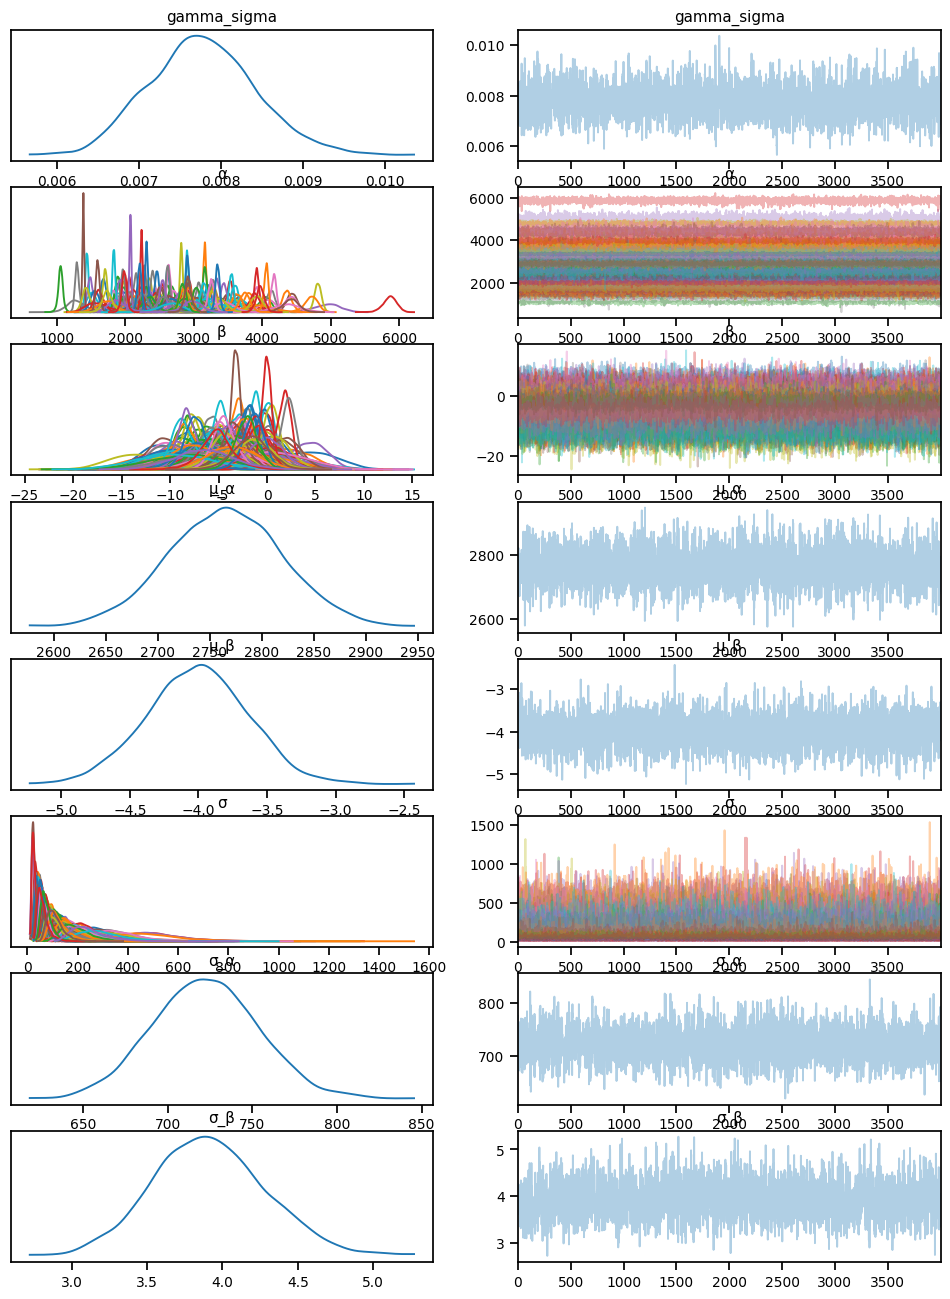

In [ ]:
az.plot_trace(az.from_numpyro(mcmc_pphs), compact=True)

In [ ]:
predictions_test_pphs = predictive_pphs(rng_key,
                                                         sample_weeks = x_test.values,
                                                         sample_patient_code = sample_patient_code_test)['fvc']

mu_predictions_test_h = predictions_test_pphs.mean(axis=0)
std_predictions_test_h = predictions_test_pphs.std(axis=0)

maes["PatrialPooled_hypersigma"] = mean_absolute_error(y_test, mu_predictions_test_h)

coverages["PatrialPooled_hypersigma"] = coverage(y_test, mu_predictions_test_h, std_predictions_test_h).item()

print(maes)
print(coverages)

{'LinearRegression': 626.3184730275215, 'PooledModel': 626.4611966040827, 'PatrialPooled_samesigma': 110.46457322643649, 'PartiallyPooled_samesigma': 110.46457322643649, 'PatrialPooled_hypersigma': 111.37391593686996}
{'pooled': 0.9483870967741935, 'PatrialPooled_samesigma': 0.9419354838709677, 'PatrialPooled_hypersigma': 0.9451612903225807}


In [ ]:
# Predict for a given patient


def predict_pphs(patient_code):
    predictions = predictive_pphs(rng_key, all_weeks, patient_code)
    mu = predictions["fvc"].mean(axis=0)
    sigma = predictions["fvc"].std(axis=0)
    return mu, sigma

# Plot the predictions for a given patient
def plot_patient_pphs(patient_code):
    mu, sigma = predict_pphs(patient_code)
    plt.scatter(all_weeks, mu)
    plt.fill_between(all_weeks, mu - 1.64*sigma, mu + 1.64*sigma, alpha=0.1)
    id_to_patient = patient_encoder.inverse_transform([patient_code])[0]
    #print(id_to_patient[0], patient_code)
    #print(patient_code, id_to_patient)
    patient_weeks = x_test.values[sample_patient_code_test == patient_code]
    patient_fvc = y_test.values[sample_patient_code_test == patient_code]
    # patient_weeks = train[train["Patient"] == id_to_patient]["Weeks"]
    # patient_fvc = train[train["Patient"] == id_to_patient]["FVC"]
    plt.scatter(patient_weeks, patient_fvc, alpha=0.8, label="Test Set", color="black")
    #plt.scatter(sample_weeks[train["patient_code"] == patient_code.item()], fvc[train["patient_code"] == patient_code.item()], alpha=0.5)
    plt.xlabel("Weeks")
    plt.ylabel("FVC")
    plt.legend()
    plt.title(patient_encoder.inverse_transform([patient_code])[0])

def plot_total_pphs(patient_id = 0, plot_pooled = False):
    print(all_weeks.shape)
    print(mu.shape)
    plot_patient_pphs(np.array([patient_id]))
    print(all_weeks.shape)
    print(mu.shape)
    if plot_pooled:
        plt.plot(all_weeks, mu, color='g')
        plt.fill_between(all_weeks, mu - 1.64*sigma, mu + 1.64*sigma, alpha=0.05, color='g')


c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


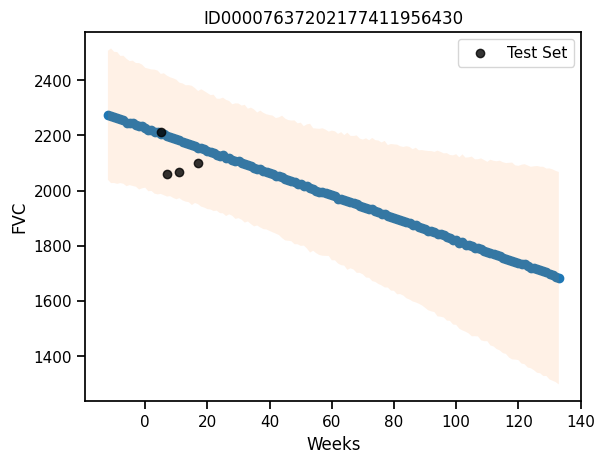

In [ ]:
# plot for a given patient
plot_patient_pphs(np.array([0]))

# Question 3
Use your version of following models to reproduce figure 4 from the paper referenced at conditional neural network paper. You can also refer to the notebook in the course.
- Hypernet
- Neural Processes

## Hyper Network

In [ ]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
# import torch.nn.functional as F
import torch.optim as optim
import os
from torch.utils.data import Dataset, DataLoader, Subset
# import torchvision.datasets as datasets
from PIL import Image

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn import preprocessing
from tqdm import trange

import os
import shutil

from tabulate import tabulate

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:3")
print(device)
current_device = device #torch.cuda.current_device()
device_name = torch.cuda.get_device_name(current_device)
print(f"Current GPU assigned: {current_device}, Name: {device_name}")

cuda:3
Current GPU assigned: cuda:3, Name: NVIDIA A100-SXM4-80GB


Celeba data [link](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)

Note book ref [link]()

### prepare data

In [ ]:
# import os

# data_root = '/home/jaiswalsuraj/suraj_work/projects/data/celeba/img_align_celeba'

# # Check if the specified directory exists
# if os.path.exists(data_root):
#     # List all files in the directory with a specific image extension (e.g., .jpg)
#     image_files = [f for f in os.listdir(data_root) if f.endswith('.jpg')]

#     # Get the count of image files
#     num_images = len(image_files)

#     print(f"Number of images in '{data_root}': {num_images}")
# else:
#     print(f"The directory '{data_root}' does not exist.")

Number of images in '/home/jaiswalsuraj/suraj_work/projects/data/celeba/img_align_celeba': 202599


In [ ]:
# data_folder_size = 200000
# data_root = '/home/jaiswalsuraj/suraj_work/projects/data/celeba/img_align_celeba'
# output_dir = f'/home/jaiswalsuraj/suraj_work/projects/data/celeba/img_align_celeba_{data_folder_size}'

# # Check if the specified input directory exists
# if os.path.exists(data_root):
#     # Ensure the output directory exists, or create it if necessary
#     if not os.path.exists(output_dir):
#         os.makedirs(output_dir)

#     # List all files in the input directory
#     all_image_files = [f for f in os.listdir(data_root) if f.endswith('.jpg')]

#     # random_images = random.sample(all_image_files, data_folder_size)
#     images_list = all_image_files[:data_folder_size]
#     # Copy the randomly selected images to the output directory
#     for image_file in images_list:
#         src_path = os.path.join(data_root, image_file)
#         dst_path = os.path.join(output_dir, image_file)
#         shutil.copy2(src_path, dst_path)

#     print(f"Successfully copied {data_folder_size} random images to '{output_dir}'.")
# else:
#     print(f"The input directory '{data_root}' does not exist.")

Successfully copied 200000 random images to '/home/jaiswalsuraj/suraj_work/projects/data/celeba/img_align_celeba_200000'.


test data: last 2599 images

In [ ]:
# data_folder_size = 2599
# data_root = '/home/jaiswalsuraj/suraj_work/projects/data/celeba/img_align_celeba'
# output_dir = f'/home/jaiswalsuraj/suraj_work/projects/data/celeba/img_align_celeba_{data_folder_size}'

# # Check if the specified input directory exists
# if os.path.exists(data_root):
#     # Ensure the output directory exists, or create it if necessary
#     if not os.path.exists(output_dir):
#         os.makedirs(output_dir)

#     # List all files in the input directory
#     all_image_files = [f for f in os.listdir(data_root) if f.endswith('.jpg')]

#     # random_images = random.sample(all_image_files, data_folder_size)
#     images_list = all_image_files[data_folder_size:]
#     # Copy the randomly selected images to the output directory
#     for image_file in images_list:
#         src_path = os.path.join(data_root, image_file)
#         dst_path = os.path.join(output_dir, image_file)
#         shutil.copy2(src_path, dst_path)

#     print(f"Successfully copied {data_folder_size} random images to '{output_dir}'.")
# else:
#     print(f"The input directory '{data_root}' does not exist.")

Successfully copied 2599 random images to '/home/jaiswalsuraj/suraj_work/projects/data/celeba/img_align_celeba_2599'.


### Extras

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, data_root, transform=None):
        self.data_root = data_root
        self.transform = transform
        self.image_files = [f for f in os.listdir(data_root) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_root, self.image_files[idx])
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image

In [ ]:
# Create a coordinate dataset from the image
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height* width, 2) and torch.tensor containing the (num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates
    x_coords = torch.arange(width).repeat(height, 1)
    y_coords = torch.arange(height).repeat(width, 1).t()
    x_coords = x_coords.reshape(-1)
    y_coords = y_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([x_coords, y_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Create a tensor containing the image pixel values
    Y = img.reshape(-1, num_channels).float().to(device)
    return X, Y

In [ ]:
def neg_loglikelyhood(y_pred,log_sigma,y_true):
    cov_matrix = torch.diag_embed(log_sigma.exp())
    dist = torch.distributions.MultivariateNormal(y_pred,cov_matrix,validate_args=False)
    return - dist.log_prob(y_true).sum()

In [ ]:
def count_params(model):
    # return torch.sum(p.numel() for p in model.parameters() if p.requires_grad)
    return torch.sum(torch.tensor([p.numel() for p in model.parameters()]))

### loading and preprocessing

In [ ]:
batch_size = 1 # keep this to 1
img_size = 32 # Change as needed

# Specify the root directory where the dataset is located
data_root = '/home/jaiswalsuraj/suraj_work/projects/data/celeba/img_align_celeba_10000'

# Define the data transformations
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),  # Resize the images to a common size (adjust as needed)
    transforms.ToTensor(),   # Convert images to tensors
])
# default shape is torch.Size([3, 218, 178])
# Create the custom dataset
celeba_dataset = CustomImageDataset(data_root, transform=transform)

# Create a data loader
data_loader = DataLoader(celeba_dataset, batch_size=batch_size, shuffle=False)

Original image after transformation

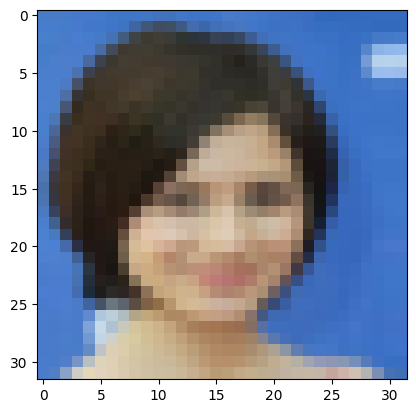

In [ ]:
plt.imshow(torch.einsum('chw -> hwc', data_loader.dataset[33]))

Original image

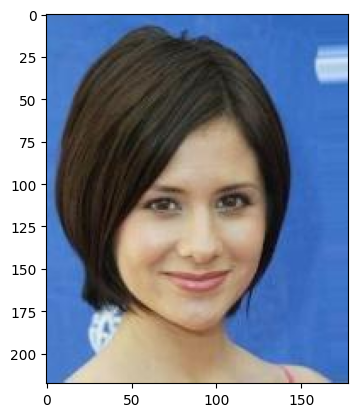

In [ ]:
plt.imshow(torch.einsum('chw -> hwc', data_loader.dataset[33]))

### model defination

#### target net defination

In [ ]:
# Create a MLP with 5 hidden layers with 256 neurons each and ReLU activations.
# Input is (x, y) and output is (r, g, b) or (g) for grayscale
# here we output 6 values (3 for RGB mean and 3 for RGB std)
s = 128 # hidden dim of model

class TargetNet(nn.Module):
    def _init_siren(self, activation_scale):
        self.fc1.weight.data.uniform_(-1/self.fc1.in_features, 1/self.fc1.in_features)
        for layers in [self.fc2, self.fc3, self.fc4, self.fc5]:
            layers.weight.data.uniform_(-np.sqrt(6/self.fc2.in_features)/activation_scale,
                                        np.sqrt(6/self.fc2.in_features)/activation_scale)

    def __init__(self, activation=torch.relu, n_out=1, activation_scale=1.0):
        super().__init__()
        self.activation = activation
        self.activation_scale = activation_scale
        self.fc1 = nn.Linear(2, s) # input size is 2 (x, y) location of pixel
        self.fc2 = nn.Linear(s, s)
        self.fc3 = nn.Linear(s, s)
        self.fc4 = nn.Linear(s, s)
        self.fc5 = nn.Linear(s, n_out) #gray scale image (1) or RGB (3)
        if self.activation == torch.sin:
            # init weights and biases for sine activation
            self._init_siren(activation_scale=self.activation_scale)

    def forward(self, x):
        x = self.activation(self.activation_scale*self.fc1(x))
        x = self.activation(self.activation_scale*self.fc2(x))
        x = self.activation(self.activation_scale*self.fc3(x))
        x = self.activation(self.activation_scale*self.fc4(x))
        return self.fc5(x)

#### Hypernetwork defination
##### Input: (x, y, R, G, B)
##### Output: Our Hypernetwork should have the output equal to the number of parameters in the main network.

In [ ]:
# pass total params of target network before calling the hypernetwork model
class HyperNet(nn.Module):
    def __init__(self, total_params, num_neurons=128, activation=torch.relu):
        super().__init__()
        self.activation = activation
        self.n_out = total_params
        self.fc1 = nn.Linear(5, num_neurons)
        self.fc2 = nn.Linear(num_neurons, num_neurons)
        self.fc3 = nn.Linear(num_neurons, self.n_out)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        return self.fc3(x)

### Initialize the model and input

#### Initialize the target network

In [ ]:
from torchinfo import summary
targetnet = TargetNet(activation=torch.relu, n_out=6, activation_scale=1).to(device)
summary(targetnet, input_size=(img_size* img_size, 2)) #32*32 =1024 is the image size lentgh, 2 is x,y coordinate
# outputs 6: 1,2,3 mean of each channel and 4,5,6 are log sigma of each channel

Layer (type:depth-idx)                   Output Shape              Param #
TargetNet                                [1024, 6]                 --
├─Linear: 1-1                            [1024, 128]               384
├─Linear: 1-2                            [1024, 128]               16,512
├─Linear: 1-3                            [1024, 128]               16,512
├─Linear: 1-4                            [1024, 128]               16,512
├─Linear: 1-5                            [1024, 6]                 774
Total params: 50,694
Trainable params: 50,694
Non-trainable params: 0
Total mult-adds (M): 51.91
Input size (MB): 0.01
Forward/backward pass size (MB): 4.24
Params size (MB): 0.20
Estimated Total Size (MB): 4.45

In [ ]:
targetnet

TargetNet(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=6, bias=True)
)

In [ ]:
count_params(targetnet)

tensor(50694)

#### initialize the hypernetwork model

In [ ]:
hypernet = HyperNet(total_params=count_params(targetnet), activation=torch.sin).to(device)
print(hypernet)

HyperNet(
  (fc1): Linear(in_features=5, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=50694, bias=True)
)


In [ ]:
summary(hypernet,input_size=(img_size* img_size,5))  # 32*32 = 1024 is the image size length, 5 is the input(x,y,r,g,b) to hypernet

Layer (type:depth-idx)                   Output Shape              Param #
HyperNet                                 [1024, 50694]             --
├─Linear: 1-1                            [1024, 128]               768
├─Linear: 1-2                            [1024, 128]               16,512
├─Linear: 1-3                            [1024, 50694]             6,539,526
Total params: 6,556,806
Trainable params: 6,556,806
Non-trainable params: 0
Total mult-adds (G): 6.71
Input size (MB): 0.02
Forward/backward pass size (MB): 417.38
Params size (MB): 26.23
Estimated Total Size (MB): 443.63

In [ ]:
table_data = []
total_params = 0
start = 0
start_end_mapping = {}
for name, param in targetnet.named_parameters():
    param_count = torch.prod(torch.tensor(param.shape)).item()
    total_params += param_count
    end = total_params
    table_data.append([name, param.shape, param_count, start, end])
    start_end_mapping[name] = (start, end)
    start = end

print(tabulate(table_data, headers=["Layer Name", "Shape", "Parameter Count", "Start Index", "End Index"]))
print(f"Total number of parameters: {total_params}")

Layer Name    Shape                     Parameter Count    Start Index    End Index
------------  ----------------------  -----------------  -------------  -----------
fc1.weight    torch.Size([128, 2])                  256              0          256
fc1.bias      torch.Size([128])                     128            256          384
fc2.weight    torch.Size([128, 128])              16384            384        16768
fc2.bias      torch.Size([128])                     128          16768        16896
fc3.weight    torch.Size([128, 128])              16384          16896        33280
fc3.bias      torch.Size([128])                     128          33280        33408
fc4.weight    torch.Size([128, 128])              16384          33408        49792
fc4.bias      torch.Size([128])                     128          49792        49920
fc5.weight    torch.Size([6, 128])                  768          49920        50688
fc5.bias      torch.Size([6])                         6          50688      

#### initialize the input

In [ ]:
corr, vals = create_coordinate_map(data_loader.dataset[0])
corr, vals

(tensor([[ 0.,  0.],
         [ 1.,  0.],
         [ 2.,  0.],
         ...,
         [29., 31.],
         [30., 31.],
         [31., 31.]], device='cuda:3'),
 tensor([[0.4510, 0.4706, 0.4824],
         [0.4745, 0.4745, 0.4471],
         [0.4667, 0.4353, 0.5412],
         ...,
         [0.0314, 0.0549, 0.0471],
         [0.0431, 0.0392, 0.0510],
         [0.0549, 0.0392, 0.0549]], device='cuda:3'))

In [ ]:
scaler_img = preprocessing.MinMaxScaler().fit(corr.cpu())
xy = torch.tensor(scaler_img.transform(corr.cpu())).float().to(device)
xy, xy.shape

(tensor([[0.0000, 0.0000],
         [0.0323, 0.0000],
         [0.0645, 0.0000],
         ...,
         [0.9355, 1.0000],
         [0.9677, 1.0000],
         [1.0000, 1.0000]], device='cuda:3'),
 torch.Size([1024, 2]))

### Training loop

In [ ]:
n_epochs=20
lr = 0.003

targetnet = TargetNet(activation=torch.relu, n_out=6, activation_scale=1).to(device)
hypernet = HyperNet(total_params=count_params(targetnet), activation=torch.relu).to(device)
optimizer = optim.Adam(hypernet.parameters(),lr=lr) # only hypernet is updated

n_context = 100
print("Context Points=",n_context)
for epoch in trange(n_epochs):

    c_idx = np.array(random.sample(range(1023),n_context))

    print("Epoch=",epoch+1)
    epoch_loss = 0
    i=1

    for data in data_loader:
        # print(data.shape)
        optimizer.zero_grad()

        pixel_intensity = data.reshape(3,-1).T.to(device).float()
        input = torch.concatenate([xy[c_idx],pixel_intensity[c_idx]],axis=1).float()

        hyper_out = hypernet(input)
        hyper_out = torch.mean(hyper_out,dim=0)

        target_dict ={}
        for name,param in targetnet.named_parameters():
            start,end = start_end_mapping[name]
            target_dict[name] = hyper_out[start:end].reshape(param.shape)

        img_out = torch.func.functional_call(targetnet, target_dict, xy)
        # print(img_out.shape, img_out[:,:3].shape, img_out[:,3:].shape, pixel_intensity.shape)
        # print( img_out[:,:3], img_out[:,3:], pixel_intensity)
        loss = neg_loglikelyhood(img_out[:,:3],img_out[:,3:],pixel_intensity)
        loss.backward()
        optimizer.step()

        epoch_loss = epoch_loss + loss.item()
        i=i+1

    print("Epoch Loss=",epoch_loss/len(data_loader))


Context Points= 100


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch= 1


  5%|▌         | 1/20 [01:05<20:42, 65.40s/it]

Epoch Loss= -395.47315481672285
Epoch= 2


 10%|█         | 2/20 [02:10<19:37, 65.41s/it]

Epoch Loss= -915.5049703121185
Epoch= 3


 15%|█▌        | 3/20 [03:15<18:29, 65.26s/it]

Epoch Loss= -1166.0503022047044
Epoch= 4


 20%|██        | 4/20 [04:21<17:24, 65.28s/it]

Epoch Loss= -1349.56748127985
Epoch= 5


 25%|██▌       | 5/20 [05:26<16:19, 65.30s/it]

Epoch Loss= -1396.8538594449997
Epoch= 6


 30%|███       | 6/20 [06:31<15:14, 65.31s/it]

Epoch Loss= -1479.6613237543106
Epoch= 7


 35%|███▌      | 7/20 [07:37<14:09, 65.36s/it]

Epoch Loss= -1449.8615832103728
Epoch= 8


 40%|████      | 8/20 [08:42<13:04, 65.38s/it]

Epoch Loss= -1528.4998937654495
Epoch= 9


 45%|████▌     | 9/20 [09:47<11:58, 65.31s/it]

Epoch Loss= -1538.7266953744888
Epoch= 10


 50%|█████     | 10/20 [10:53<10:53, 65.36s/it]

Epoch Loss= -1574.4109719749451
Epoch= 11


 55%|█████▌    | 11/20 [11:58<09:48, 65.35s/it]

Epoch Loss= -1558.2231241334914
Epoch= 12


 60%|██████    | 12/20 [13:03<08:42, 65.32s/it]

Epoch Loss= -1585.886608516693
Epoch= 13


 65%|██████▌   | 13/20 [14:09<07:36, 65.27s/it]

Epoch Loss= -1586.6056880670546
Epoch= 14


 70%|███████   | 14/20 [15:14<06:31, 65.23s/it]

Epoch Loss= -1561.2374246302604
Epoch= 15


 75%|███████▌  | 15/20 [16:19<05:25, 65.20s/it]

Epoch Loss= -1606.3488553873062
Epoch= 16


 80%|████████  | 16/20 [17:24<04:20, 65.24s/it]

Epoch Loss= -1637.4123486403466
Epoch= 17


 85%|████████▌ | 17/20 [18:30<03:15, 65.29s/it]

Epoch Loss= -1656.406247360611
Epoch= 18


 90%|█████████ | 18/20 [19:33<02:09, 64.69s/it]

Epoch Loss= -1621.5405502536773
Epoch= 19


 95%|█████████▌| 19/20 [20:38<01:04, 64.88s/it]

Epoch Loss= -1708.3212175039291
Epoch= 20


100%|██████████| 20/20 [21:44<00:00, 65.21s/it]

Epoch Loss= -1700.857941632271


### saving and loading the model

In [ ]:
torch.save(hypernet.state_dict(), 'hypernet_model_10000.pth')
torch.save(targetnet.state_dict(), 'targetnet_model_10000.pth')

In [ ]:
# Load the hypernet and targetnet models
hypernet = HyperNet(total_params=count_params(targetnet), activation=torch.relu).to(device)
hypernet.load_state_dict(torch.load('hypernet_model_10000.pth'))
hypernet.eval()  # Set the model to evaluation mode


HyperNet(
  (fc1): Linear(in_features=5, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=50694, bias=True)
)

In [ ]:
targetnet = TargetNet(activation=torch.relu, n_out=6, activation_scale=1).to(device)
targetnet.load_state_dict(torch.load('targetnet_model_10000.pth'))
targetnet.eval()

TargetNet(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=6, bias=True)
)

### Plots

loading the test data

In [ ]:
batch_size = 1 # keep this to 1
img_size = 32 # Change as needed

# Specify the root directory where the dataset is located
data_root = '/home/jaiswalsuraj/suraj_work/projects/data/celeba/img_align_celeba_2599'

# Define the data transformations
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),  # Resize the images to a common size (adjust as needed)
    transforms.ToTensor(),   # Convert images to tensors
])
# default shape is torch.Size([3, 218, 178])
# Create the custom dataset
celeba_dataset = CustomImageDataset(data_root, transform=transform)

# Create a data loader
test_data_loader = DataLoader(celeba_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
def plot_hypernet(data,hypernet,targetnet,c_idx):

    pixel_intensity = data.reshape(3,-1).T.to(device).float()
    input = torch.concatenate([xy[c_idx],pixel_intensity[c_idx]],axis=1).float()

    hyper_out = hypernet(input) # hyper_out is a tensor of shape (n_context, total_params)
    hyper_out = torch.mean(hyper_out,dim=0) # aggregate across context points

    target_dict ={}
    start = 0
    for name,param in targetnet.named_parameters():
        end = start + param.numel()
        target_dict[name] = hyper_out[start:end].reshape(param.shape)
        start = end

    img_out = torch.func.functional_call(targetnet, target_dict, xy)
    return img_out.cpu().detach()

In [ ]:
c_1 = np.array(random.sample(range(img_size*img_size),1))
c_10 = np.array(random.sample(range(img_size*img_size),10))
c_100 = np.array(random.sample(range(img_size*img_size),100))
c_1000 = np.array(random.sample(range(img_size*img_size),1000))

image_any = test_data_loader.dataset[0]
idx = 0
data = image_any

In [ ]:
plt.figure(figsize=(9,7),constrained_layout=True)
plt.suptitle("HyperNetworks",fontsize=20)
def plot_image(i,j,k, data,hypernet,targetnet, c_idx):
    plt.subplot(i,j,k)
    img = data.permute(1,2,0)
    mask = np.zeros((32,32,3))
    mask[c_idx//32,c_idx%32,:] = 1
    plt.imshow(img*mask)
    plt.title(f"Context: {len(c_idx)}")
    plt.axis('off')

    plt.subplot(i,j,k+4)
    plot_image = plot_hypernet(data,hypernet,targetnet,c_idx)
    plt.imshow(plot_image[:,:3].T.reshape(3,32,32).permute(1,2,0))
    plt.axis('off')

    plt.subplot(i,j,k+8)
    var =plot_image[:,3:].exp().T.reshape(3,32,32).permute(1,2,0)
    var = var-var.min()
    var = var/var.max()
    plt.imshow(var)
    plt.axis('off')

<Figure size 900x700 with 0 Axes>

In [ ]:
data.shape

torch.Size([3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/jaiswalsuraj/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


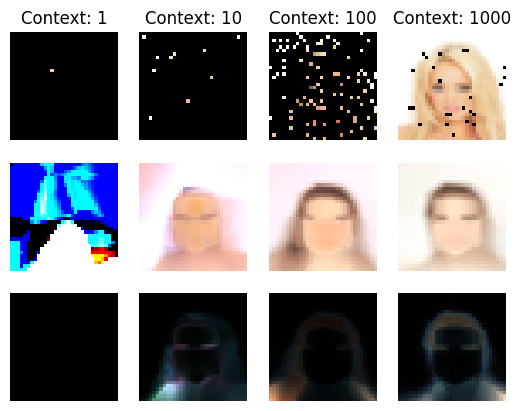

In [ ]:
plot_image(3,4,1,data,hypernet,targetnet,c_1)
plot_image(3,4,2,data,hypernet,targetnet,c_10)
plot_image(3,4,3,data,hypernet,targetnet,c_100)
plot_image(3,4,4,data,hypernet,targetnet,c_1000)

## Neural Processes

Celeba data [link](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)

Note book ref [link]()

### loading and preprocessing

In [ ]:
batch_size = 1 # keep this to 1
img_size = 32 # Change as needed

# Specify the root directory where the dataset is located
data_root = '/home/jaiswalsuraj/suraj_work/projects/data/celeba/img_align_celeba_10000'

# Define the data transformations
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),  # Resize the images to a common size (adjust as needed)
    transforms.ToTensor(),        # Convert images to tensors
])
# default shape is torch.Size([3, 218, 178])
# Create the custom dataset
celeba_dataset = CustomImageDataset(data_root, transform=transform)

# Create a data loader
data_loader = DataLoader(celeba_dataset, batch_size=batch_size, shuffle=True)

Original image after transformation

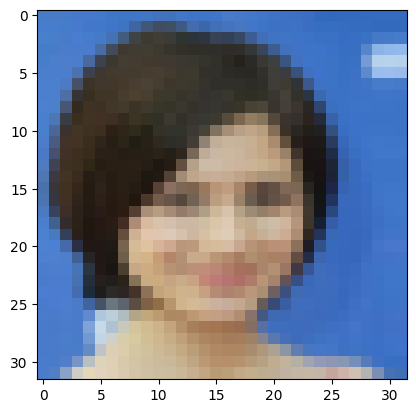

In [ ]:
plt.imshow(torch.einsum('chw -> hwc', data_loader.dataset[33]))

Original image

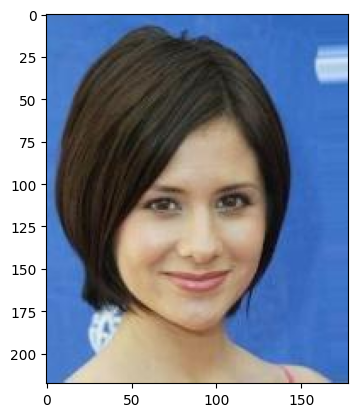

In [ ]:
plt.imshow(torch.einsum('chw -> hwc', data_loader.dataset[33]))

#### Encoder Decoder model defination

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim,activation=torch.sin,activation_scale=30.0):
        super().__init__()
        self.activation = activation
        self.activation_scale = activation_scale
        if activation != torch.sin:
            self.activation_scale = 1.0

        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, z_dim)

    def forward(self, x):
        x = self.activation(self.linear1(x)*self.activation_scale)
        x = self.activation(self.linear2(x)*self.activation_scale)
        return self.linear3(x)

class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, output_dim,activation=torch.sin,activation_scale=30.0):
        super().__init__()
        self.activation = activation
        self.activation_scale = activation_scale
        if activation != torch.sin:
            self.activation_scale = 1.0
        self.linear1 = nn.Linear(z_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, hidden_dim)
        self.linear4 = nn.Linear(hidden_dim, hidden_dim)
        self.linear5 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.activation(self.linear1(x)*self.activation_scale)
        x = self.activation(self.linear2(x)*self.activation_scale)
        x = self.activation(self.linear3(x)*self.activation_scale)
        x = self.activation(self.linear4(x)*self.activation_scale)
        return self.linear5(x)

In [ ]:
from torchinfo import summary
encoder = Encoder(5, 256, 128, activation=torch.relu,activation_scale=1)
summary(encoder,input_size=(img_size*img_size,5)) # 32*32 = 1024 is the image size length, 5 is the input(x,y,r,g,b) to hypernet

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [1024, 128]               --
├─Linear: 1-1                            [1024, 256]               1,536
├─Linear: 1-2                            [1024, 256]               65,792
├─Linear: 1-3                            [1024, 128]               32,896
Total params: 100,224
Trainable params: 100,224
Non-trainable params: 0
Total mult-adds (M): 102.63
Input size (MB): 0.02
Forward/backward pass size (MB): 5.24
Params size (MB): 0.40
Estimated Total Size (MB): 5.66

In [ ]:
print(encoder)

Encoder(
  (linear1): Linear(in_features=5, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=128, bias=True)
)


In [ ]:
decoder = Decoder(130, 256, 6, activation=torch.relu,activation_scale=1)
summary(decoder,input_size=(img_size*img_size,130))

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [1024, 6]                 --
├─Linear: 1-1                            [1024, 256]               33,536
├─Linear: 1-2                            [1024, 256]               65,792
├─Linear: 1-3                            [1024, 256]               65,792
├─Linear: 1-4                            [1024, 256]               65,792
├─Linear: 1-5                            [1024, 6]                 1,542
Total params: 232,454
Trainable params: 232,454
Non-trainable params: 0
Total mult-adds (M): 238.03
Input size (MB): 0.53
Forward/backward pass size (MB): 8.44
Params size (MB): 0.93
Estimated Total Size (MB): 9.90

In [ ]:
print(decoder)

Decoder(
  (linear1): Linear(in_features=130, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=256, bias=True)
  (linear4): Linear(in_features=256, out_features=256, bias=True)
  (linear5): Linear(in_features=256, out_features=6, bias=True)
)


#### initialize the input

In [ ]:
corr, vals = create_coordinate_map(data_loader.dataset[0])
corr, vals

(tensor([[ 0.,  0.],
         [ 1.,  0.],
         [ 2.,  0.],
         ...,
         [29., 31.],
         [30., 31.],
         [31., 31.]], device='cuda:2'),
 tensor([[0.4510, 0.4706, 0.4824],
         [0.4745, 0.4745, 0.4471],
         [0.4667, 0.4353, 0.5412],
         ...,
         [0.0314, 0.0549, 0.0471],
         [0.0431, 0.0392, 0.0510],
         [0.0549, 0.0392, 0.0549]], device='cuda:2'))

In [ ]:
scaler_img = preprocessing.MinMaxScaler().fit(corr.cpu())
xy = torch.tensor(scaler_img.transform(corr.cpu())).float().to(device)
xy, xy.shape

(tensor([[0.0000, 0.0000],
         [0.0323, 0.0000],
         [0.0645, 0.0000],
         ...,
         [0.9355, 1.0000],
         [0.9677, 1.0000],
         [1.0000, 1.0000]], device='cuda:2'),
 torch.Size([1024, 2]))

### Training loop

In [ ]:
n_epochs=20
lr = 0.003
n_context = 200
print("Context Points=",n_context)

encoder = Encoder(input_dim=5, hidden_dim=512, z_dim=128,activation=torch.relu,activation_scale=1).to(device)
decoder = Decoder(z_dim=130, hidden_dim=512, output_dim=6,activation=torch.relu,activation_scale=1).to(device)
optimizer = optim.Adam(list(encoder.parameters())+list(decoder.parameters()),lr=lr)

for epoch in trange(n_epochs):

    c_idx = np.array(random.sample(range(1023),n_context))

    print("Epoch=",epoch+1)
    epoch_loss = 0
    i=1
    for data in data_loader:
        # print(data.shape)

        optimizer.zero_grad()

        pixel_intensity = data.reshape(3,-1).T.to(device).float()
        input = torch.concatenate([xy[c_idx],pixel_intensity[c_idx]],axis=1).float()

        encoder_out = encoder(input)
        encoder_out = torch.mean(encoder_out,dim=0)

        decoder_in = encoder_out.repeat(1024,1)
        decoder_in = torch.concatenate([xy,decoder_in],axis=1)

        img_out = decoder(decoder_in)

        loss = neg_loglikelyhood(img_out[:,:3],img_out[:,3:],pixel_intensity)
        loss.backward()
        optimizer.step()

        epoch_loss = epoch_loss + loss.item()
        i=i+1
    print("Epoch Loss=",epoch_loss/len(data_loader))


Context Points= 200


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch= 1


  5%|▌         | 1/20 [00:58<18:27, 58.30s/it]

Epoch Loss= 47.26116828255653
Epoch= 2


 10%|█         | 2/20 [01:50<16:27, 54.89s/it]

Epoch Loss= -455.4421627301693
Epoch= 3


 15%|█▌        | 3/20 [02:43<15:16, 53.92s/it]

Epoch Loss= -683.1707640041351
Epoch= 4


 20%|██        | 4/20 [03:35<14:13, 53.32s/it]

Epoch Loss= -761.2885692318916
Epoch= 5


 25%|██▌       | 5/20 [04:36<13:56, 55.78s/it]

Epoch Loss= -827.9153870079041
Epoch= 6


 30%|███       | 6/20 [05:35<13:20, 57.17s/it]

Epoch Loss= -938.4062066322326
Epoch= 7


 35%|███▌      | 7/20 [06:30<12:11, 56.24s/it]

Epoch Loss= -1007.5277942465782
Epoch= 8


 40%|████      | 8/20 [07:30<11:28, 57.39s/it]

Epoch Loss= -1048.726986592865
Epoch= 9


 45%|████▌     | 9/20 [08:20<10:06, 55.15s/it]

Epoch Loss= -1057.8311284263611
Epoch= 10


 50%|█████     | 10/20 [09:17<09:17, 55.74s/it]

Epoch Loss= -1070.1760208235742
Epoch= 11


 55%|█████▌    | 11/20 [09:56<07:34, 50.50s/it]

Epoch Loss= -1065.5062245418549
Epoch= 12


 60%|██████    | 12/20 [10:35<06:16, 47.06s/it]

Epoch Loss= -1078.0465439793586
Epoch= 13


 65%|██████▌   | 13/20 [11:14<05:13, 44.75s/it]

Epoch Loss= -1088.4120592634201
Epoch= 14


 70%|███████   | 14/20 [11:53<04:17, 42.99s/it]

Epoch Loss= -1078.4957633354188
Epoch= 15


 75%|███████▌  | 15/20 [12:32<03:28, 41.78s/it]

Epoch Loss= -1084.8360796244622
Epoch= 16


 80%|████████  | 16/20 [13:11<02:43, 40.94s/it]

Epoch Loss= -1093.4410486424447
Epoch= 17


 85%|████████▌ | 17/20 [13:50<02:01, 40.44s/it]

Epoch Loss= -1113.8205106693267
Epoch= 18


 90%|█████████ | 18/20 [14:29<01:19, 39.99s/it]

Epoch Loss= -1110.6333978479386
Epoch= 19


 95%|█████████▌| 19/20 [15:25<00:44, 44.66s/it]

Epoch Loss= -1098.3281953195572
Epoch= 20


100%|██████████| 20/20 [16:25<00:00, 49.28s/it]

Epoch Loss= -1106.2516599431992


### saving and loading the model

In [ ]:
torch.save(encoder.state_dict(), 'encoder_model_10000.pth')
torch.save(decoder.state_dict(), 'decoder_model_10000.pth')

In [ ]:
# Load the hypernet and targetnet models
encoder = Encoder(input_dim=5, hidden_dim=128, z_dim=128,activation=torch.relu,activation_scale=1).to(device)

encoder.load_state_dict(torch.load('encoder_model_10000.pth'))
encoder.eval()  # Set the model to evaluation mode


Encoder(
  (linear1): Linear(in_features=5, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=128, bias=True)
)

In [ ]:
decoder = Decoder(z_dim=130, hidden_dim=256, output_dim=6,activation=torch.relu,activation_scale=1).to(device)
decoder.load_state_dict(torch.load('decoder_model_10000.pth'))
decoder.eval()

Decoder(
  (linear1): Linear(in_features=130, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=256, bias=True)
  (linear4): Linear(in_features=256, out_features=256, bias=True)
  (linear5): Linear(in_features=256, out_features=6, bias=True)
)

### Plots

Loading the test data

In [ ]:
batch_size = 1 # keep this to 1
img_size = 32 # Change as needed

# Specify the root directory where the dataset is located
data_root = '/home/jaiswalsuraj/suraj_work/projects/data/celeba/img_align_celeba_2599'

# Define the data transformations
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),  # Resize the images to a common size (adjust as needed)
    transforms.ToTensor(),   # Convert images to tensors
])
# default shape is torch.Size([3, 218, 178])
# Create the custom dataset
celeba_dataset = CustomImageDataset(data_root, transform=transform)

# Create a data loader
test_data_loader = DataLoader(celeba_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
def plot_enc_dec(data,encoder,decoder,c_idx):

    pixel_intensity = data.reshape(3,-1).T.to(device).float()
    input = torch.concatenate([xy[c_idx],pixel_intensity[c_idx]],axis=1).float()

    encoder_out = encoder(input)
    encoder_out = torch.mean(encoder_out,dim=0)

    decoder_in = encoder_out.repeat(1024,1)
    decoder_in = torch.concatenate([xy,decoder_in],axis=1)

    img_out = decoder(decoder_in)
    return img_out.cpu().detach()

In [ ]:
c_1 = np.array(random.sample(range(img_size*img_size),1))
c_10 = np.array(random.sample(range(img_size*img_size),10))
c_100 = np.array(random.sample(range(img_size*img_size),100))
c_1000 = np.array(random.sample(range(img_size*img_size),1000))

idx = 5
image_any = test_data_loader.dataset[idx]
data = image_any

In [ ]:
plt.figure(figsize=(9,7),constrained_layout=True)
plt.suptitle("Neural process",fontsize=20)
def plot_image(i,j,k, data,encoder,decoder, c_idx):
    plt.subplot(i,j,k)
    img = data.permute(1,2,0)
    mask = np.zeros((32,32,3))
    mask[c_idx//32,c_idx%32,:] = 1
    plt.imshow(img*mask)
    plt.title(f"Context: {len(c_idx)}")
    plt.axis('off')

    plt.subplot(i,j,k+4)
    plot_image = plot_enc_dec(data,encoder,decoder,c_idx)
    plt.imshow(plot_image[:,:3].T.reshape(3,32,32).permute(1,2,0))
    plt.axis('off')

    plt.subplot(i,j,k+8)
    var =plot_image[:,3:].exp().T.reshape(3,32,32).permute(1,2,0)
    var = var-var.min()
    var = var/var.max()
    plt.imshow(var)
    plt.axis('off')

<Figure size 900x700 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


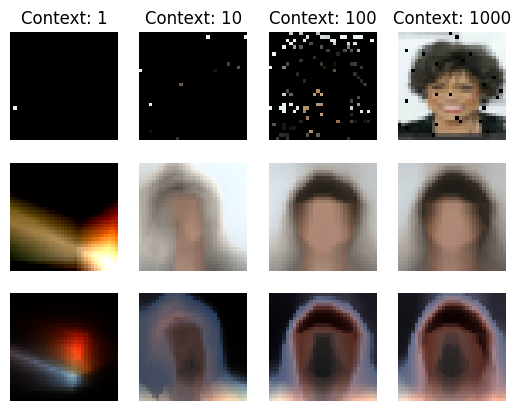

In [ ]:
plot_image(3,4,1,data,encoder,decoder,c_1)
plot_image(3,4,2,data,encoder,decoder,c_10)
plot_image(3,4,3,data,encoder,decoder,c_100)
plot_image(3,4,4,data,encoder,decoder,c_1000)

# Question 4.
Write the Random walk Metropolis Hastings algorithms from scratch. Take 1000 samples using below given log probs and compare the mean and covariance matrix with hamiltorch’s standard HMC and emcee’s Metropolis Hastings implementation. Use 500 samples as the burn/warm up samples. Also check the relation between acceptance ratio and the sigma of the proposal distribution in your from scratch implementation. Use the log likelihood function given below.
```python3
import torch.distributions as D
def log_likelihood(omega):
    omega = torch.tensor(omega)
    mean = torch.tensor([0., 0.])
    stddev = torch.tensor([0.5, 1.])
    return D.MultivariateNormal(mean, torch.diag(stddev**2)).log_prob(omega).sum()
```

In [ ]:
import torch.distributions as D


def log_likelihood(omega):
    mean = torch.tensor([0., 0.])
    stddev = torch.tensor([0.5, 1.])
    return D.MultivariateNormal(mean, torch.diag(stddev**2)).log_prob(omega).sum()

#Numpy implementation for emcee
def logprob(omega):
    mean = np.array([0.0, 0.0])
    stddev = np.array([0.5, 1.0])
    cov_matrix = np.diag(stddev**2)
    return -0.5 * np.log(2 * np.pi) * 2 - 0.5 * np.sum((omega - mean) * np.linalg.solve(cov_matrix, (omega - mean).T), axis=0)

#Pytorch implementation for hamiltorch
def logprob_tensor(omega):
    mean = torch.tensor([0.0, 0.0])
    stddev = torch.tensor([0.5, 1.0])
    cov_matrix = torch.diag(stddev**2)
    return -0.5 * torch.log(torch.tensor(2 * torch.pi)) * 2 - 0.5 * torch.sum((omega - mean) * torch.inverse(cov_matrix) @ (omega - mean).T, axis=0)


In [ ]:
def random_walk_metropolis_hastings(log_likelihood, initial_state, num_samples, proposal_stddev):
    samples = [initial_state]
    accepted_samples = 0

    current_state = initial_state
    for _ in range(num_samples):
        proposal = current_state + proposal_stddev * torch.randn(*(current_state.shape))

        # Calculate the log-likelihood of the proposal
        log_likelihood_proposal = log_likelihood(proposal)

        # Calculate the log-likelihood of the current state
        log_likelihood_current = log_likelihood(current_state)

        # Calculate the acceptance ratio
        acceptance_ratio = log_likelihood_proposal - log_likelihood_current

        # Calculate the proposal distribution probability (it's a normal distribution)
        proposal_distribution = D.Normal(current_state, proposal_stddev)
        proposal_prob = proposal_distribution.log_prob(proposal)

        # Accept or reject the proposal
        # acceptance_ratio += proposal_prob - log_likelihood_proposal  # Include the proposal distribution
        if torch.log(D.uniform.Uniform(0, 1).sample()) <= acceptance_ratio:
            current_state = proposal
            accepted_samples += 1

        samples.append(current_state)

    acceptance_rate = accepted_samples / num_samples
    return torch.stack(samples), acceptance_rate


In [ ]:
# Set the initial state and proposal standard deviation
initial_state = torch.tensor([0.0001, 0.0001])
proposal_stddev = 1
num_samples = 1000
burn_in_samples = 500

In [ ]:
# Generate samples using the RWMH algorithm
samples,  acceptance_rate = random_walk_metropolis_hastings(log_likelihood, initial_state, num_samples, proposal_stddev)

# Discard the burn-in samples
burned_samples = samples[burn_in_samples:]


# Calculate mean and covariance matrix
mean = burned_samples.mean(dim=0)
covariance_matrix = torch.matmul((burned_samples - mean).T, (burned_samples - mean)) / (burned_samples.size(0) - 1)



print("RWMH Acceptance Rate:", acceptance_rate)
print("RWMH Mean:", mean)
print("RWMH Covariance Matrix:", covariance_matrix)


RWMH Acceptance Rate: 0.385
RWMH Mean: tensor([ 0.0767, -0.0569])
RWMH Covariance Matrix: tensor([[ 0.2547, -0.0530],
        [-0.0530,  0.8120]])


Text(0.5, 1.0, 'Samples from the RWMH algorithm')

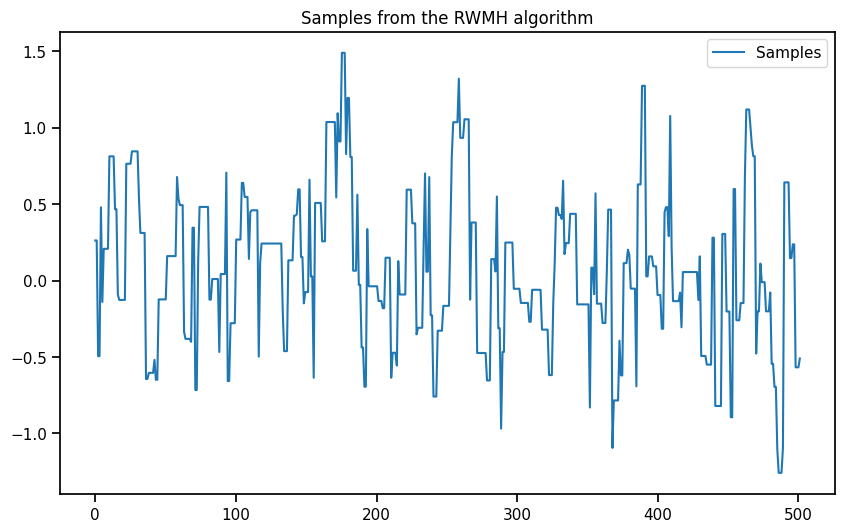

In [ ]:
# Plot the samples

plt.figure(figsize=(10, 6))
plt.plot( np.linspace(0, burned_samples.size(0), burned_samples.size(0)),burned_samples.numpy()[:, 0], label="Samples")
plt.legend()
plt.title("Samples from the RWMH algorithm")

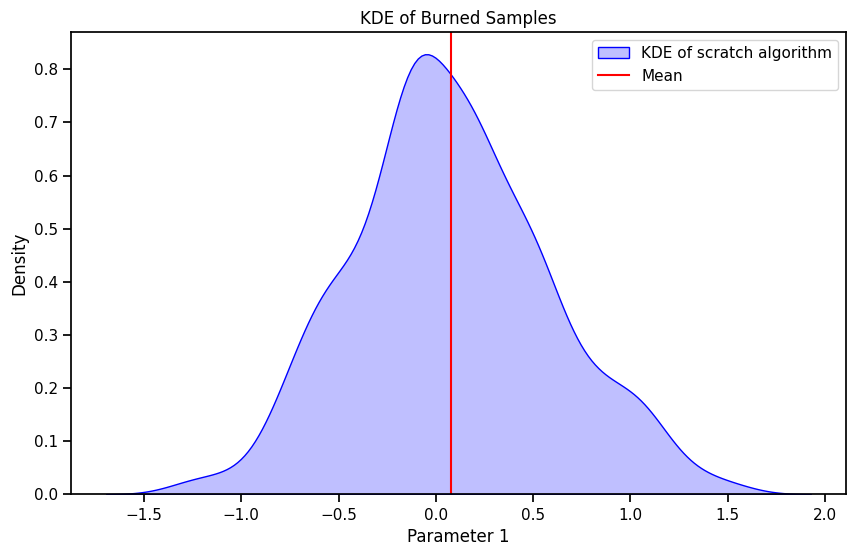

In [ ]:
# Plot the KDE of the burned samples
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.kdeplot(burned_samples.numpy()[:, 0], fill=True, color="blue", label="KDE of scratch algorithm")
plt.axvline(mean[0], color="red", label="Mean")

plt.xlabel('Parameter 1')
plt.ylabel('Density')
plt.title('KDE of Burned Samples')
plt.legend()
plt.show()

Correlation between acceptance ratio and the sigma of the proposal distribution

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:15<00:00,  2.63s/it]


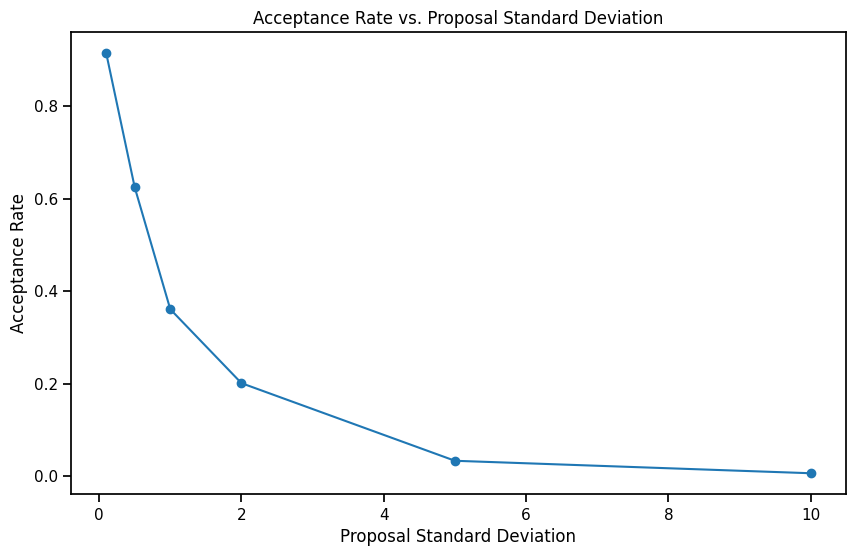

In [ ]:
import tqdm
prop_stdev_list = [0.1, 0.5, 1, 2, 5, 10]
acceptance_rates = []

for prop_stdev in tqdm.tqdm(prop_stdev_list):
    _, acceptance_rate = random_walk_metropolis_hastings(log_likelihood, initial_state, num_samples, prop_stdev)
    acceptance_rates.append(acceptance_rate)

plt.figure(figsize=(10, 6))
plt.plot(prop_stdev_list, acceptance_rates, marker='o')
plt.xlabel("Proposal Standard Deviation")
plt.ylabel("Acceptance Rate")
plt.title("Acceptance Rate vs. Proposal Standard Deviation")
plt.show()

As the sigma of the proposal distribution increases, the acceptance ratio decreases. This is because the proposal distribution is more spread out and the probability of the new sample being accepted is lower. When the sigma is low, we are always sampling from a small region around the current sample and the probability of the new sample being accepted is higher.

Autocorrelation time: 3.94 steps


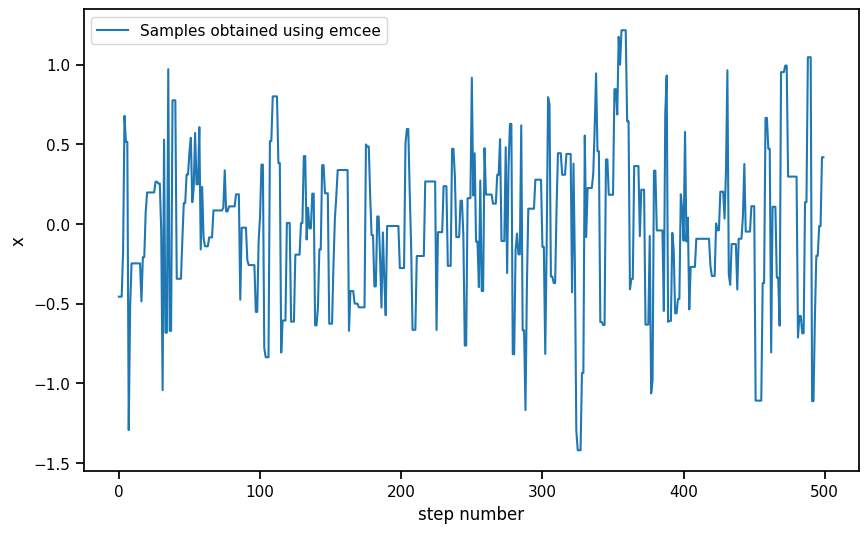

In [ ]:
# np.random.seed(93284)
import emcee

init = np.array([[0.000001], [0.000002]])
nwalkers, ndim = init.shape


sampler = emcee.EnsembleSampler(
    nwalkers,
    ndim,
    logprob,
    moves=[
        emcee.moves.GaussianMove(proposal_stddev)
    ],

)
sampler.run_mcmc(init, 1000, )

print(
    "Autocorrelation time: {0:.2f} steps".format(
        sampler.get_autocorr_time()[0]
    )
)

plt.figure(figsize=(10, 6))
plt.plot(sampler.get_chain()[burn_in_samples:, 0, 0], label = 'Samples obtained using emcee')
plt.xlabel("step number")
plt.ylabel("x")
plt.legend()

In [ ]:
mean_emcee = torch.tensor([np.mean(sampler.get_chain()[500:, 0, 0]),np.mean(sampler.get_chain()[500:, 1, 0])])
torch_emcee_samples = torch.tensor([sampler.get_chain()[500:, 0, 0], sampler.get_chain()[500:, 1, 0]])
covariance_matrix_emcee = torch.matmul((torch_emcee_samples.T - mean_emcee).T, (torch_emcee_samples.T - mean_emcee)) / (torch_emcee_samples.T.size(0) - 1)

print("RWMH Acceptance Rate(emcee implementation):", np.mean(sampler.acceptance_fraction))
print("RWMH Mean(emcee implementation):", mean_emcee)
print("RWMH Covariance Matrix(emcee implementation):", covariance_matrix_emcee)

RWMH Acceptance Rate(emcee implementation): 0.45899999999999996
RWMH Mean(emcee implementation): tensor([-0.0174, -0.0024], dtype=torch.float64)
RWMH Covariance Matrix(emcee implementation): tensor([[0.2241, 0.0122],
        [0.0122, 0.1906]], dtype=torch.float64)


C:\Users\Dell\AppData\Local\Temp\ipykernel_14380\699697460.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(sampler.get_chain()[500:, 0, 0], shade=True, color="red", label="KDE of samples using emcee")


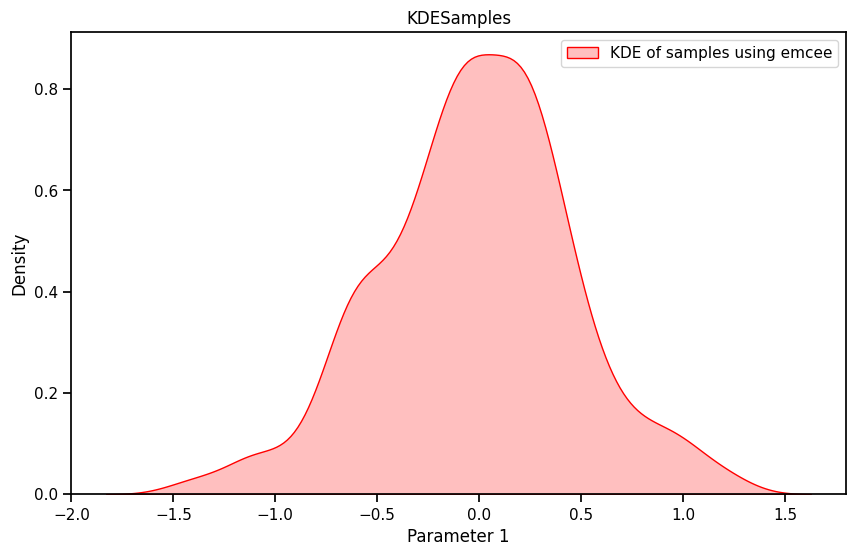

In [ ]:
# Plot the KDE of the burned samples
import seaborn as sns
plt.figure(figsize=(10, 6))
# sns.kdeplot(burned_samples.numpy()[:, 0], shade=True, color="blue", label="KDE")

sns.kdeplot(sampler.get_chain()[500:, 0, 0], shade=True, color="red", label="KDE of samples using emcee")



plt.xlabel('Parameter 1')
plt.ylabel('Density')
plt.title('KDESamples')
plt.legend()
plt.show()

In [ ]:
import hamiltorch


# Initial state
x0 = torch.tensor([0.0,0.0])
num_samples = 1000
step_size = 1
num_steps_per_sample = 1
hamiltorch.set_random_seed(123)

params_hmc = hamiltorch.sample(log_prob_func=logprob_tensor, params_init=x0,
                               num_samples=num_samples, step_size=step_size,
                               num_steps_per_sample=num_steps_per_sample)


Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 1000/1000 | 667.00         
Acceptance Rate 0.49


In [ ]:
params_hmc = torch.stack(params_hmc)


mean_hamil = params_hmc.mean(dim=0)
covariance_matrix_hamil = torch.matmul((params_hmc - mean_hamil).T, (params_hmc - mean_hamil)) / (params_hmc.size(0) - 1)

print("RWMH Mean:", mean_hamil)
print("RWMH Covariance Matrix:", covariance_matrix_hamil)

RWMH Mean: tensor([-0.0168,  0.0195])
RWMH Covariance Matrix: tensor([[0.2350, 0.0216],
        [0.0216, 1.0323]])


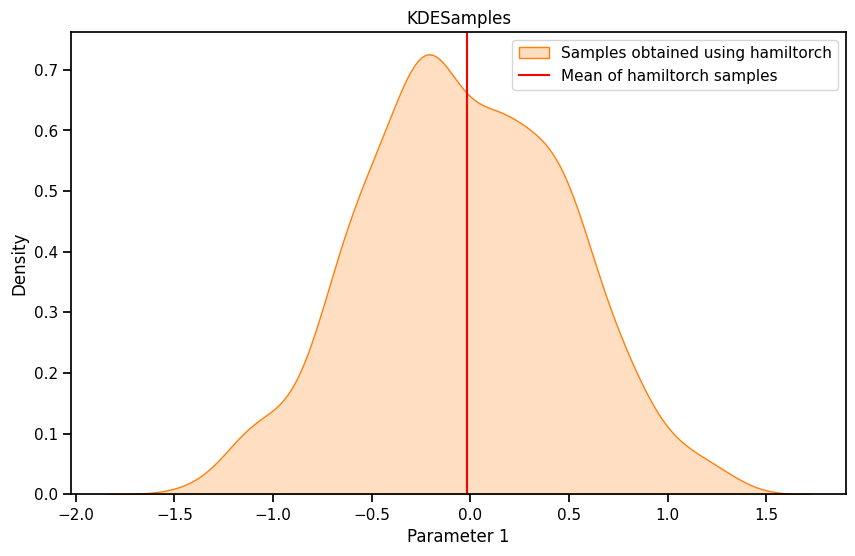

In [ ]:
# Plot the KDE of the burned samples
import seaborn as sns
plt.figure(figsize=(10, 6))
# sns.kdeplot(burned_samples.numpy()[:, 0], shade=True, color="blue", label="KDE")

sns.kdeplot(params_hmc.numpy()[500:,0], fill=True, color='C1', label = 'Samples obtained using hamiltorch')
plt.axvline(mean_hamil[0], color="red", label="Mean of hamiltorch samples")


plt.xlabel('Parameter 1')
plt.ylabel('Density')
plt.title('KDESamples')
plt.legend()
plt.show()

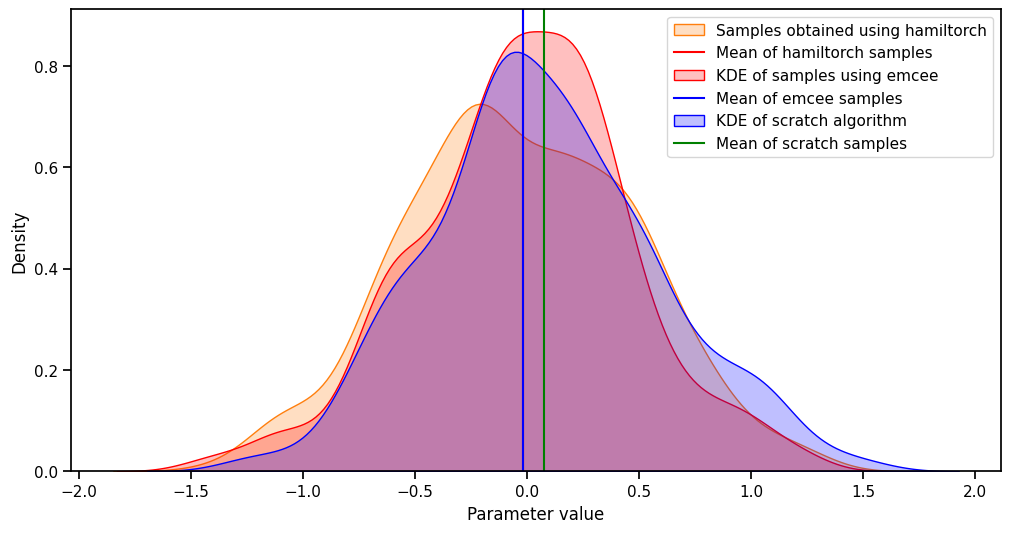

In [ ]:
# KDE plot
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.kdeplot(params_hmc.numpy()[500:,0], fill=True, color='C1', label = 'Samples obtained using hamiltorch')
plt.axvline(mean_hamil[0], color="red", label="Mean of hamiltorch samples")
sns.kdeplot(sampler.get_chain()[500:, 0, 0], fill=True, color="red", label="KDE of samples using emcee")
plt.axvline(mean_emcee[0], color="blue", label="Mean of emcee samples")
sns.kdeplot(burned_samples.numpy()[:, 0], fill=True, color="blue", label="KDE of scratch algorithm")
plt.axvline(mean[0], color="green", label="Mean of scratch samples")


# plt.plot(x_lin, y_lin, label='Ground truth')
plt.xlabel('Parameter value')
plt.ylabel('Density')
plt.legend()

From the above distribution, we can see that our scratch implementation is similar to hamiltorch’s standard HMC and emcee’s Metropolis Hastings implementation.

In [ ]:
import numpy as np
from numpy.linalg import norm

# Assuming cov1 and cov2 are your covariance matrices
frobenius_norm = norm(covariance_matrix_hamil- covariance_matrix_emcee, 'fro')
print("Frobenius norm for hamiltorch and emcee:", frobenius_norm)

frobenius_norm = norm(covariance_matrix_hamil- covariance_matrix, 'fro')
print("Frobenius norm for hamiltorch and scratch:", frobenius_norm)

frobenius_norm = norm(covariance_matrix_emcee- covariance_matrix, 'fro')
print("Frobenius norm for emcee and scratch:", frobenius_norm)

Frobenius norm for hamiltorch and emcee: 0.8417977279587513
Frobenius norm for hamiltorch and scratch: 0.24498351
Frobenius norm for emcee and scratch: 0.6288880822849502


C:\Users\Dell\AppData\Local\Temp\ipykernel_14380\989267052.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


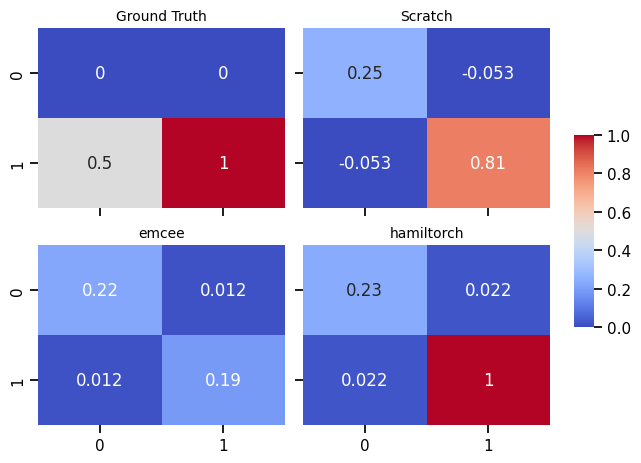

In [ ]:
import seaborn as sns

# Create a sample covariance matrix (replace this with your own data)
cov_matrix = np.array([[0, 0], [0.5, 1.0]])
cov_matrices = [cov_matrix, covariance_matrix, covariance_matrix_emcee, covariance_matrix_hamil]
plt_titles = ['Ground Truth', 'Scratch', 'emcee', 'hamiltorch']

# Create a list of colors for the colorbar
cmap = plt.get_cmap("viridis")

fig, axn = plt.subplots(2, 2, sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i, ax in enumerate(axn.flat):
    # Specify color and other properties of the colorbar
    cbar_kws = {
        "orientation": "vertical",
        "label": "Colorbar Label",
        "cmap": cmap,
    }

    sns.heatmap(cov_matrices[i], ax=ax,
                cbar=i == 0,
                vmin=0, vmax=1,
                cbar_ax=None if i else cbar_ax,
                cmap = "coolwarm",annot=True)  # Pass cbar_kws
    ax.set_title(f'{plt_titles[i]}', fontsize=10)
fig.tight_layout(rect=[0, 0, .9, 1])

plt.show()
